# **Tarea 2 Inteligencia Computacional**
## Support Vector Machine (SVM)
### María José Liberona T. 

In [ ]:
#Tarea 2 Inteligencia Computacional 
#María José Liberona Tobar

#Importación de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

#Subir documentos  
#Se debe subir el documento magic04.data
from google.colab import files
uploaded = files.upload()

Saving magic04.data to magic04.data


In [ ]:
# 1. Implementar un código que lea el dataset, usando pandas.
columnas=['fLength', 'fWidth', 'fSize', 'fConc', 'fConcl', 'fAsym', 'fM3Long', 'fM3Trans','fAlpha', 'fDist', 'class'] #Nombre de las columnas
m_datos=pd.read_csv('magic04.data', names=columnas) #Lee el documento y asignar los nombres a las columnas
m_datos


,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [ ]:
# 2. Re-muestrear el dataset usando pandas, de modo que contenga 3.000 ejemplos de la clase positiva,
#y 3.000 ejemplos de la clase negativa.

#Primero se dividirán los grupos por clase utilizando la función 'pd.dataframe.groupby('class').get_group('g/h')
#Obs: la función '.reset_index(drop=True)' redefine los índices de las filas
#Clase no-hadrón ('g')
m_g=m_datos.groupby('class').get_group('g').reset_index(drop=True)
#Clase hadrón ('h')
m_h=m_datos.groupby('class').get_group('h').reset_index(drop=True)

#Luego, se implementa la función 'pd.dataframe.sample()' que permite elegir al azar un número determinado de filas
#Clase no-hadrón
m_data_g=m_g.sample(n=3000, replace=False).reset_index(drop=True)
(filas_g,colum_g)=m_data_g.shape
#Clase hadrón
m_data_h=m_h.sample(n=3000, replace=False).reset_index(drop=True)
(filas_h,colum_h)=m_data_h.shape

#print(m_data_g) #Muestra 3000 datos de clase no-hadrón
#print(m_data_h) #Muestra 3000 datos de clase hadrón

union_m=pd.concat([m_data_g, m_data_h]) #Une los dataframe que contienen 3000 muestras de 'h' y 3000 de 'g'
datos=union_m.sample(frac=1.0).reset_index(drop=True)
(filas_datos,colum_datos)=datos.shape

#Proporción de las clases en la data original 
print('Proporción data original de no hadrón (g): '+str(filas_g/filas_datos))
print('Proporción data original de hadrón (h): '+str(filas_h/filas_datos))

#Muestra los datos base
#print(datos)
datos


Proporción data original de no hadrón (g): 0.5
Proporción data original de hadrón (h): 0.5


,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,14.1721,7.7370,2.4843,0.4963,0.3027,30.2651,24.1343,-3.3950,33.1110,124.4584,h
1,39.9730,8.8352,2.5996,0.6457,0.3205,35.1519,35.3912,3.5384,36.3987,178.1124,h
2,102.3369,25.8713,3.2714,0.1219,0.0878,-22.0600,-38.8742,18.3080,79.7161,81.1097,h
3,26.2768,14.0731,2.4362,0.4212,0.2253,-12.6384,7.3769,-13.9195,75.6791,105.5910,g
4,30.8539,22.9645,2.6618,0.2680,0.1340,6.6522,26.4484,-4.6784,41.3740,186.4030,g
...,...,...,...,...,...,...,...,...,...,...,...
5995,18.5389,10.1402,2.2923,0.6276,0.3138,3.1107,-9.8429,-6.0326,42.4560,148.1560,h
5996,72.5175,60.6466,3.5614,0.1599,0.0849,40.7764,56.9624,-23.7941,81.9920,328.7533,h
5997,28.3933,18.0348,2.5226,0.4728,0.2348,7.7879,20.8174,-11.3260,55.3045,193.6363,h
5998,23.0874,14.8181,2.5085,0.5643,0.2961,-13.4753,-15.5049,8.5711,2.2829,195.0480,g


In [ ]:
# 3.  Dividir la base de datos en 3 conjuntos representativos: entrenamiento (60%), validación (20%) y
# prueba (20%). Compruebe la representatividad de éstos, verificando si la proporción de cada clase
# se mantiene cercana a la proporción del conjunto completo.

#Separación en entrenamiento, validación y prueba
data_train, data_vp=train_test_split(datos,train_size=0.6,test_size=0.4,shuffle=False)
data_val, data_test=train_test_split(data_vp,train_size=0.5,test_size=0.5,shuffle=False)

#Tamaño conjuntos de entrenamiento, validación y prueba
(filas_train,colum_train)=data_train.shape
(filas_val,colum_val)=data_val.shape 
(filas_test,colum_test)=data_test.shape

#Proporción de las clases en los diferentes conjuntos (train, test, val)
#Entrenamiento (train)
train_g=data_train.groupby('class').get_group('g')
(filas_train_g,colum_train_g)=train_g.shape
train_h=data_train.groupby('class').get_group('h')
(filas_train_h,colum_train_h)=train_h.shape

print('Proporción data train de no hadrón (g): '+str(filas_train_g/filas_train))
print('Proporción data train de hadrón (h): '+str(filas_train_h/filas_train))

#Test
test_g=data_test.groupby('class').get_group('g')
(filas_test_g,colum_test_g)=test_g.shape
test_h=data_test.groupby('class').get_group('h')
(filas_test_h,colum_test_h)=test_h.shape

print('Proporción data test de no hadrón (g): '+str(filas_test_g/filas_test))
print('Proporción data test de hadrón (h): '+str(filas_test_h/filas_test))

#Validación
val_g=data_val.groupby('class').get_group('g')
(filas_val_g,colum_val_g)=val_g.shape
val_h=data_val.groupby('class').get_group('h')
(filas_val_h,colum_val_h)=val_h.shape

print('Proporción data validación de no hadrón (g): '+str(filas_val_g/filas_val))
print('Proporción data validación de hadrón (h): '+str(filas_val_h/filas_val))

#print(data_train)
#print(data_val)
#print(data_test)
data_test

Proporción data train de no hadrón (g): 0.4975
Proporción data train de hadrón (h): 0.5025
Proporción data test de no hadrón (g): 0.49
Proporción data test de hadrón (h): 0.51
Proporción data validación de no hadrón (g): 0.5175
Proporción data validación de hadrón (h): 0.4825


,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
4800,24.6829,8.8025,2.4417,0.4431,0.2583,34.2271,-17.9715,-11.4317,68.5378,78.1400,h
4801,83.3455,18.5871,2.8315,0.3920,0.2837,-55.2217,-64.8864,-17.6264,12.9110,284.6520,g
4802,33.6825,16.3260,2.7247,0.3487,0.1781,34.6867,-22.9435,-14.9478,11.7631,164.7560,g
4803,21.7632,12.4786,2.3627,0.5249,0.2712,28.7016,-8.0145,4.3910,26.1310,152.4440,g
4804,19.1141,12.2076,2.4676,0.5554,0.3186,-3.8694,10.6297,10.5675,48.2306,177.9120,h
...,...,...,...,...,...,...,...,...,...,...,...
5995,18.5389,10.1402,2.2923,0.6276,0.3138,3.1107,-9.8429,-6.0326,42.4560,148.1560,h
5996,72.5175,60.6466,3.5614,0.1599,0.0849,40.7764,56.9624,-23.7941,81.9920,328.7533,h
5997,28.3933,18.0348,2.5226,0.4728,0.2348,7.7879,20.8174,-11.3260,55.3045,193.6363,h
5998,23.0874,14.8181,2.5085,0.5643,0.2961,-13.4753,-15.5049,8.5711,2.2829,195.0480,g


In [ ]:
# 4. Entrene un StandardScaler usando las características del conjunto de entrenamiento para poder
#normalizar las características. Luego, aplíquelo a las características del conjunto de entrenamiento,
#validación y prueba.

#Entrenamiento de StandScaler a partir de los datos de entrenamiento
scaler = StandardScaler()

print(scaler.fit(data_train.iloc[:,:10])) #Calcula la media y desviación estándar 

#Normaliza las muestras 
train=scaler.transform(data_train.iloc[:,:10])
#print(train)
test=scaler.transform(data_test.iloc[:,:10])
#print(test)
val=scaler.transform(data_val.iloc[:,:10])
#print(val)


StandardScaler(copy=True, with_mean=True, with_std=True)


In [ ]:
#5. Entrenar un clasificador SVM lineal que permita discriminar
# hadrones de no-hadrones

#Opción 1: Se crea el estimador directamente desde la función GridSearchCV()
#Define el mejor valor de los parámetros
model_lineal=GridSearchCV(estimator=svm.SVC(), param_grid={'C':[0.1,5,10,50,100],'kernel':['linear']}, cv=5)
#Entrena el modelo lineal 
model_lineal.fit(train, data_train['class'])

#Opción 2: Se crea el estimador aparte utilizando los parámetros obtenidos de GridSearchCV()
#model_2=svm.SVC(kernel='linear', C=model.best_estimator_.C, probability=False)
#model_2.fit(train, data_train['class'])

#Muestra el resultado de los mejores parámetros
print(model_lineal.best_estimator_)


SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
# 6. Evaluar sobre el conjunto de validación y generar la matriz de confusión, tanto en su versión
# normalizada como no normalizada. Se recomienda usar metrics.confusión_matrix( )

#Predicción usando el modelo de la opción 1
prediccion_val=model_lineal.predict(val) 
#print(prediccion_val)

#Predicción usando el modelo de la opción 2
#prediccion_2_val=model_2.predict(val)
#print(prediccion_2_val)

#print(classification_report(data_val['class'], prediccion_val))

#Matriz de confusión sin normalizar
matriz_c=confusion_matrix(data_val['class'],prediccion_val, labels=['g','h'])
#print(matriz_c)
#Matriz de confusión normalizada con respecto a cada clase
matriz_cn=confusion_matrix(data_val['class'],prediccion_val, normalize='true', labels=['g','h'])
#print(matriz_cn)
#Matriz de confusión normalizada con respecto al total de muestras
matriz_cn2=confusion_matrix(data_val['class'],prediccion_val, normalize='all', labels=['g','h'])
print(matriz_cn2)


[[0.4275 0.09  ]
 [0.1325 0.35  ]]


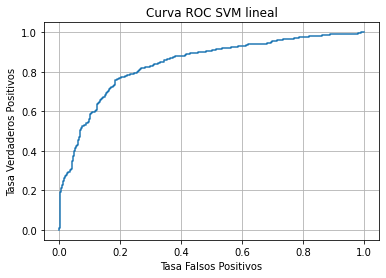

El área bajo la curva ROC es: 0.8415920613863093


In [ ]:
# 7. Generar una curva ROC que muestre el desempeño del clasificador y calcular el área bajo la curva.
# Se debe usar las funciones decision_function( ), metrics.roc_curve( ) y metrics.auc( )

#Obtiene la evaluación del modelo para cada muestra del conjunto de validación 
decision_val=model_lineal.decision_function(val)
#print(decision_val)
class_val=np.zeros(data_val['class'].size)

#Reemplazo a sistema binario 'h'= 1 y 'g'= 0
for i in range(0,data_val['class'].size):
  #Condición para reemplazar la clase real
  if data_val.iloc[i,10]=='h':
    class_val[i]=1
  if data_val.iloc[i,10]=='g':
    class_val[i]=0

#Curva ROC
FPR, TPR, thresholds = roc_curve(class_val, decision_val)

plt.plot(FPR,TPR)
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC SVM lineal')
plt.grid()
plt.show()

#Área bajo la curva ROC
area_roc=auc(FPR,TPR)
print('El área bajo la curva ROC es: '+str(area_roc))

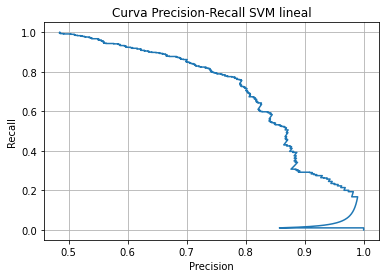

El Average Precision es: 0.8360054024843486


In [ ]:
# 8. Generar una curva precisión-recall y calcular el average precision. Se debe usar las funciones
# decision_function( ), metrics.precision_recall_curve( ) y metrics.average_precision_score( )

#Curva Precision-Recall
precision, recall, thresholds_2 = precision_recall_curve(class_val, decision_val)
plt.plot(precision,recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva Precision-Recall SVM lineal')
plt.grid()
plt.show()

#Average Precision
average=average_precision_score(class_val, decision_val)
print('El Average Precision es: '+str(average))

SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=9, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[[579  42]
 [335 244]]
[[0.93236715 0.06763285]
 [0.57858377 0.42141623]]
[[0.4825     0.035     ]
 [0.27916667 0.20333333]]


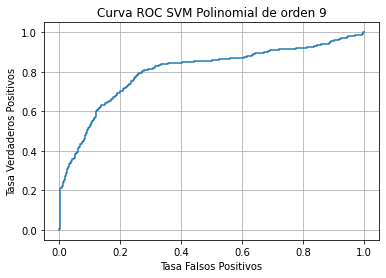

El área bajo la curva ROC es: 0.8027973156004995


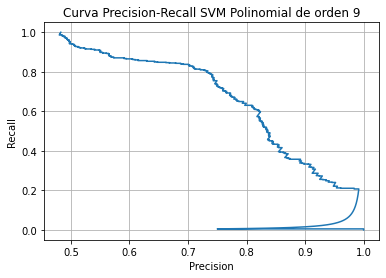

El Average Precision es: 0.8132995771123321


In [ ]:
# 9. Repetir los pasos (5), (6), (7), (8) para el caso de un SVM con kernel polinomial. Usar dos grados
# distintos del polinomio y 4 valores de C y 4 valores de gamma (parámetro del kernel) para la grilla de
#búsqueda (de parámetros).

#SVM con kernel polinomial 9
#9.5 
#Define el mejor valor de los parámetros
model_poly9=GridSearchCV(estimator=svm.SVC(), param_grid={'C':[0.1,5,10,50],'kernel':['poly'], 'gamma':[0.1,0.01,0.001,0.011], 'degree':[9]}, cv=5)
#Entrena el modelo lineal 
model_poly9.fit(train, data_train['class'])

#Muestra el resultado de los mejores parámetros
print(model_poly9.best_estimator_)

#9.6
#Predicción usando el modelo de la opción 1
prediccion_val_poly9=model_poly9.predict(val) 
#print(prediccion_val_poly9)

#Matriz de confusión sin normalizar
matriz_c_poly9=confusion_matrix(data_val['class'],prediccion_val_poly9, labels=['g','h'])
print(matriz_c_poly9)
#Matriz de confusión normalizada con respecto a cada clase
matriz_cn_poly9=confusion_matrix(data_val['class'],prediccion_val_poly9, normalize='true', labels=['g','h'])
print(matriz_cn_poly9)
#Matriz de confusión normalizada con respecto al total de muestras
matriz_cn2_poly9=confusion_matrix(data_val['class'],prediccion_val_poly9, normalize='all', labels=['g','h'])
print(matriz_cn2_poly9)

#9.7
#Obtiene la evaluación del modelo para cada muestra del conjunto de validación 
decision_val_poly9=model_poly9.decision_function(val)

#Curva ROC
FPR_poly9, TPR_poly9, thresholds_poly9 = roc_curve(class_val, decision_val_poly9)

plt.plot(FPR_poly9,TPR_poly9)
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC SVM Polinomial de orden 9')
plt.grid()
plt.show()

#Área bajo la curva ROC
area_roc_poly9=auc(FPR_poly9,TPR_poly9)
print('El área bajo la curva ROC es: '+str(area_roc_poly9))

#9.8
#Curva Precision-Recall
precision_poly9, recall_poly9, thresholds_poly9_2 = precision_recall_curve(class_val, decision_val_poly9)
plt.plot(precision_poly9,recall_poly9)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva Precision-Recall SVM Polinomial de orden 9')
plt.grid()
plt.show()

#Average Precision
average_poly9=average_precision_score(class_val, decision_val_poly9)
print('El Average Precision es: '+str(average_poly9))



In [ ]:
print(model_poly9.best_estimator_)

SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=9, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[[575  46]
 [203 376]]
[[0.92592593 0.07407407]
 [0.35060449 0.64939551]]
[[0.47916667 0.03833333]
 [0.16916667 0.31333333]]


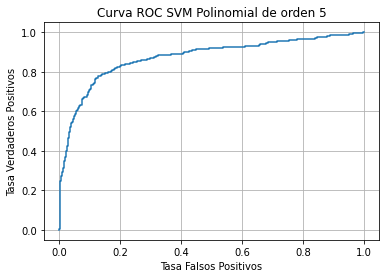

El área bajo la curva ROC es: 0.8734727819356489


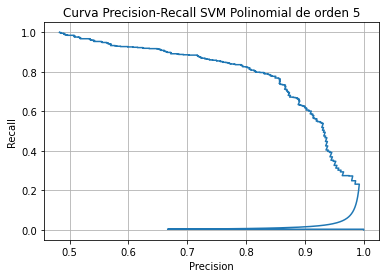

El Average Precision es: 0.8789924648595084


In [ ]:
#9
#SVM con kernel polinomial 5
#9.5 
#Define el mejor valor de los parámetros
model_poly5=GridSearchCV(estimator=svm.SVC(), param_grid={'C':[0.1,5,10,50],'kernel':['poly'], 'gamma':[0.1,0.01,0.001,0.011], 'degree':[5]}, cv=5)
#Entrena el modelo lineal 
model_poly5.fit(train, data_train['class'])

#Muestra el resultado de los mejores parámetros
print(model_poly5.best_estimator_)

#9.6
#Predicción usando el modelo de la opción 1
prediccion_val_poly5=model_poly5.predict(val) 
#print(prediccion_val_poly3)

#Matriz de confusión sin normalizar
matriz_c_poly5=confusion_matrix(data_val['class'],prediccion_val_poly5, labels=['g','h'])
print(matriz_c_poly5)
#Matriz de confusión normalizada
matriz_cn_poly5=confusion_matrix(data_val['class'],prediccion_val_poly5, normalize='true', labels=['g','h'])
print(matriz_cn_poly5)
#Matriz de confusión normalizada con respecto al total de muestras
matriz_cn2_poly5=confusion_matrix(data_val['class'],prediccion_val_poly5, normalize='all', labels=['g','h'])
print(matriz_cn2_poly5)

#9.7
#Obtiene la evaluación del modelo para cada muestra del conjunto de validación 
decision_val_poly5=model_poly5.decision_function(val)

#Curva ROC
FPR_poly5, TPR_poly5, thresholds_poly5 = roc_curve(class_val, decision_val_poly5)

plt.plot(FPR_poly5,TPR_poly5)
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC SVM Polinomial de orden 5')
plt.grid()
plt.show()

#Área bajo la curva ROC
area_roc_poly5=auc(FPR_poly5,TPR_poly5)
print('El área bajo la curva ROC es: '+str(area_roc_poly5))

#9.8
#Curva Precision-Recall
precision_poly5, recall_poly5, thresholds_poly5_2 = precision_recall_curve(class_val, decision_val_poly5)
plt.plot(precision_poly5,recall_poly5)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva Precision-Recall SVM Polinomial de orden 5')
plt.grid()
plt.show()

#Average Precision
average_poly5=average_precision_score(class_val, decision_val_poly5)
print('El Average Precision es: '+str(average_poly5))

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[[561  60]
 [118 461]]
[[0.90338164 0.09661836]
 [0.20379965 0.79620035]]
[[0.4675     0.05      ]
 [0.09833333 0.38416667]]


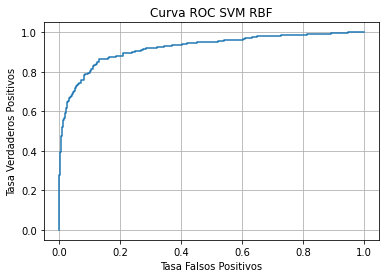

El área bajo la curva ROC es: 0.9218598338520243


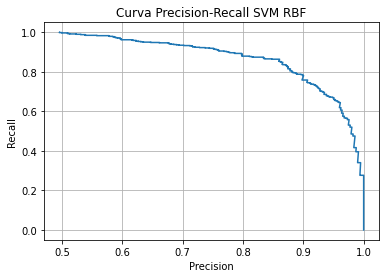

El Average Precision es: 0.9305055043822776


In [ ]:
# 10. Repetir los pasos (5), (6), (7), (8) para el caso de un SVM con kernel RBF. Usar 5 valores de C y 4
#valores de gamma (parámetro del kernel) para la grilla de búsqueda (de parámetros)..

#10.5 
#Define el mejor valor de los parámetros
model_rbf=GridSearchCV(estimator=svm.SVC(), param_grid={'C':[0.1,5,10,50,100],'kernel':['rbf'], 'gamma':[0.1,0.01,0.001,0.011]}, cv=5)
#Entrena el modelo lineal 
model_rbf.fit(train, data_train['class'])

#Muestra el resultado de los mejores parámetros
print(model_rbf.best_estimator_)

#10.6
#Predicción usando el modelo de la opción 1
prediccion_val_rbf=model_rbf.predict(val) 
#print(prediccion_val_poly3)

#Matriz de confusión sin normalizar
matriz_c_rbf=confusion_matrix(data_val['class'],prediccion_val_rbf, labels=['g','h'])
print(matriz_c_rbf)
#Matriz de confusión normalizada con respecto a cada clase
matriz_cn_rbf=confusion_matrix(data_val['class'],prediccion_val_rbf, normalize='true', labels=['g','h'])
print(matriz_cn_rbf)
#Matriz de confusión normalizada con respecto al total de muestras
matriz_cn2_rbf=confusion_matrix(data_val['class'],prediccion_val_rbf, normalize='all', labels=['g','h'])
print(matriz_cn2_rbf)

#10.7
#Obtiene la evaluación del modelo para cada muestra del conjunto de validación 
decision_val_rbf=model_rbf.decision_function(val)

#Curva ROC
FPR_rbf, TPR_rbf, thresholds_rbf = roc_curve(class_val, decision_val_rbf)

plt.plot(FPR_rbf,TPR_rbf)
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC SVM RBF')
plt.grid()
plt.show()

#Área bajo la curva ROC
area_roc_rbf=auc(FPR_rbf,TPR_rbf)
print('El área bajo la curva ROC es: '+str(area_roc_rbf))

#10.8
#Curva Precision-Recall
precision_rbf, recall_rbf, thresholds_rbf_2 = precision_recall_curve(class_val, decision_val_rbf)
plt.plot(precision_rbf,recall_rbf)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva Precision-Recall SVM RBF')
plt.grid()
plt.show()

#Average Precision
average_rbf=average_precision_score(class_val, decision_val_rbf)
print('El Average Precision es: '+str(average_rbf))


[[475 113]
 [163 449]]
[[0.80782313 0.19217687]
 [0.26633987 0.73366013]]
[[0.39583333 0.09416667]
 [0.13583333 0.37416667]]


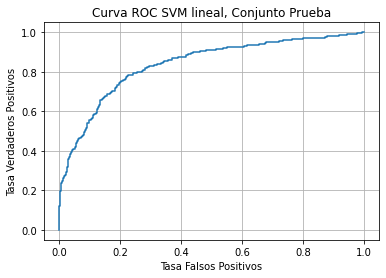

El área bajo la curva ROC es: 0.8376850740296119


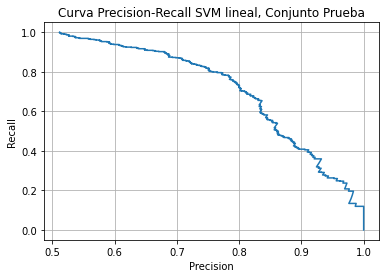

El Average Precision es: 0.8521849852166361
[[547  41]
 [324 288]]
[[0.93027211 0.06972789]
 [0.52941176 0.47058824]]
[[0.45583333 0.03416667]
 [0.27       0.24      ]]


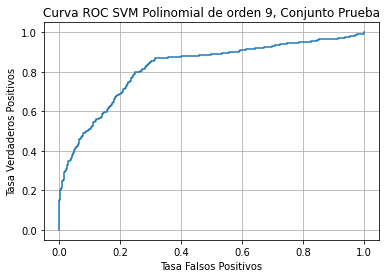

El área bajo la curva ROC es: 0.8207783113245298


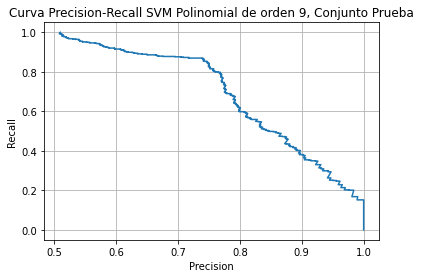

El Average Precision es: 0.8407757690764877
[[540  48]
 [197 415]]
[[0.91836735 0.08163265]
 [0.32189542 0.67810458]]
[[0.45       0.04      ]
 [0.16416667 0.34583333]]


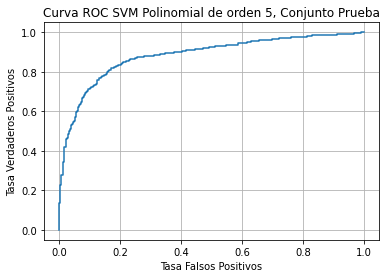

El área bajo la curva ROC es: 0.8827141967898271


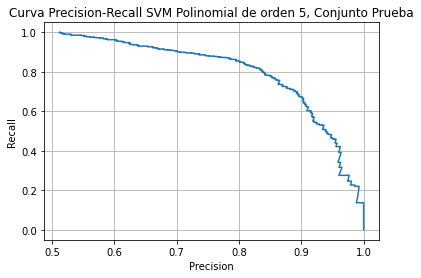

El Average Precision es: 0.8981989558286616
[[523  65]
 [129 483]]
[[0.88945578 0.11054422]
 [0.21078431 0.78921569]]
[[0.43583333 0.05416667]
 [0.1075     0.4025    ]]


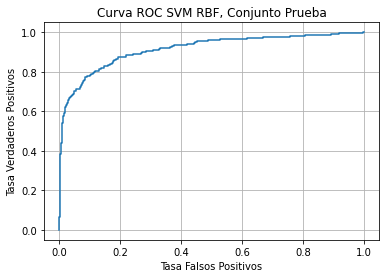

El área bajo la curva ROC es: 0.9145963941132008


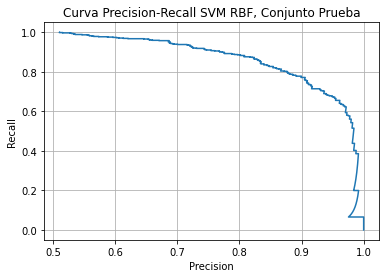

El Average Precision es: 0.92809973514578


In [ ]:
# 11. Evaluar el mejor clasificador obtenido sobre el conjunto de prueba, reportando las métricas indicadas
# en (6), (7) y (8). Considerar los casos de SVM lineal, SVM con kernel polinomial (2 grados distintos
#de polinomio) y SVM con kernel RBF.

# Este desarrollo es análogo al aplicado al conjunto de validación 

#Clasificador Lineal 
# 6. Evaluar sobre el conjunto de validación y generar la matriz de confusión, tanto en su versión
# normalizada como no normalizada. Se recomienda usar metrics.confusión_matrix( )

#Predicción usando el modelo de la opción 1
prediccion_test=model_lineal.predict(test) 
#print(prediccion_test)

#Matriz de confusión sin normalizar
matriz_c_test=confusion_matrix(data_test['class'],prediccion_test, labels=['g','h'])
print(matriz_c_test)
#Matriz de confusión normalizada con respecto a cada clase
matriz_cn_test=confusion_matrix(data_test['class'],prediccion_test, normalize='true', labels=['g','h'])
print(matriz_cn_test)
#Matriz de confusión normalizada con respecto al total de muestras
matriz_cn2_test=confusion_matrix(data_test['class'],prediccion_test, normalize='all', labels=['g','h'])
print(matriz_cn2_test)

#7. Generar una curva ROC que muestre el desempeño del clasificador y calcular el área bajo la curva.
# Se debe usar las funciones decision_function( ), metrics.roc_curve( ) y metrics.auc( )

#Obtiene la evaluación del modelo para cada muestra del conjunto de validación 
decision_test=model_lineal.decision_function(test)
#print(decision_val)
class_test=np.zeros(data_test['class'].size)

#Reemplazo a sistema binario 'h'= 1 y 'g'= 0
for i in range(0,data_test['class'].size):
  #Condición para reemplazar la clase real
  if data_test.iloc[i,10]=='h':
    class_test[i]=1
  if data_test.iloc[i,10]=='g':
    class_test[i]=0

#Curva ROC
FPR_test, TPR_test, thresholds_test = roc_curve(class_test, decision_test)

plt.plot(FPR_test,TPR_test)
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC SVM lineal, Conjunto Prueba')
plt.grid()
plt.show()

#Área bajo la curva ROC
area_roc_test=auc(FPR_test,TPR_test)
print('El área bajo la curva ROC es: '+str(area_roc_test))

# 8. Generar una curva precisión-recall y calcular el average precision. Se debe usar las funciones
# decision_function( ), metrics.precision_recall_curve( ) y metrics.average_precision_score( )

#Curva Precision-Recall
precision_test, recall_test, thresholds_2_test = precision_recall_curve(class_test, decision_test)
plt.plot(precision_test,recall_test)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva Precision-Recall SVM lineal, Conjunto Prueba')
plt.grid()
plt.show()

#Average Precision
average_test=average_precision_score(class_test, decision_test)
print('El Average Precision es: '+str(average_test))

#Clasificador SVM con kernel polinomial de grado 9
#9.6
#Predicción usando el modelo de la opción 1
prediccion_test_poly9=model_poly9.predict(test) 
#print(prediccion_test_poly9)

#Matriz de confusión sin normalizar
matriz_c_poly9_test=confusion_matrix(data_test['class'],prediccion_test_poly9, labels=['g','h'])
print(matriz_c_poly9_test)
#Matriz de confusión normalizada con respecto a cada clase
matriz_cn_poly9_test=confusion_matrix(data_test['class'],prediccion_test_poly9, normalize='true', labels=['g','h'])
print(matriz_cn_poly9_test)
#Matriz de confusión normalizada con respecto al total de muestras
matriz_cn2_poly9_test=confusion_matrix(data_test['class'],prediccion_test_poly9, normalize='all', labels=['g','h'])
print(matriz_cn2_poly9_test)

#9.7
#Obtiene la evaluación del modelo para cada muestra del conjunto de validación 
decision_test_poly9=model_poly9.decision_function(test)

#Curva ROC
FPR_poly9_test, TPR_poly9_test, thresholds_poly9_test = roc_curve(class_test, decision_test_poly9)

plt.plot(FPR_poly9_test,TPR_poly9_test)
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC SVM Polinomial de orden 9, Conjunto Prueba')
plt.grid()
plt.show()

#Área bajo la curva ROC
area_roc_poly9_test=auc(FPR_poly9_test,TPR_poly9_test)
print('El área bajo la curva ROC es: '+str(area_roc_poly9_test))

#9.8
#Curva Precision-Recall
precision_poly9_test, recall_poly9_test, thresholds_poly9_2_test = precision_recall_curve(class_test, decision_test_poly9)
plt.plot(precision_poly9_test,recall_poly9_test)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva Precision-Recall SVM Polinomial de orden 9, Conjunto Prueba')
plt.grid()
plt.show()

#Average Precision
average_poly9_test=average_precision_score(class_test, decision_test_poly9)
print('El Average Precision es: '+str(average_poly9_test))

#SVM con kernel polinomial 5

#9.6
#Predicción usando el modelo de la opción 1
prediccion_test_poly5=model_poly5.predict(test) 
#print(prediccion_test_poly3)

#Matriz de confusión sin normalizar
matriz_c_poly5_test=confusion_matrix(data_test['class'],prediccion_test_poly5, labels=['g','h'])
print(matriz_c_poly5_test)
#Matriz de confusión normalizada
matriz_cn_poly5_test=confusion_matrix(data_test['class'],prediccion_test_poly5, normalize='true', labels=['g','h'])
print(matriz_cn_poly5_test)
#Matriz de confusión normalizada con respecto al total de muestras
matriz_cn2_poly5_test=confusion_matrix(data_test['class'],prediccion_test_poly5, normalize='all', labels=['g','h'])
print(matriz_cn2_poly5_test)

#9.7
#Obtiene la evaluación del modelo para cada muestra del conjunto de validación 
decision_test_poly5=model_poly5.decision_function(test)

#Curva ROC
FPR_poly5_test, TPR_poly5_test, thresholds_poly5_test = roc_curve(class_test, decision_test_poly5)

plt.plot(FPR_poly5_test,TPR_poly5_test)
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC SVM Polinomial de orden 5, Conjunto Prueba')
plt.grid()
plt.show()

#Área bajo la curva ROC
area_roc_poly5_test=auc(FPR_poly5_test,TPR_poly5_test)
print('El área bajo la curva ROC es: '+str(area_roc_poly5_test))

#9.8
#Curva Precision-Recall
precision_poly5_test, recall_poly5_test, thresholds_poly5_2_test = precision_recall_curve(class_test, decision_test_poly5)
plt.plot(precision_poly5_test,recall_poly5_test)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva Precision-Recall SVM Polinomial de orden 5, Conjunto Prueba')
plt.grid()
plt.show()

#Average Precision
average_poly5_test=average_precision_score(class_test, decision_test_poly5)
print('El Average Precision es: '+str(average_poly5_test))

#Clasificador SVM RBF
#10.6
#Predicción usando el modelo de la opción 1
prediccion_test_rbf=model_rbf.predict(test) 
#print(prediccion_test_poly3)

#Matriz de confusión sin normalizar
matriz_c_rbf_test=confusion_matrix(data_test['class'],prediccion_test_rbf, labels=['g','h'])
print(matriz_c_rbf_test)
#Matriz de confusión normalizada con respecto a cada clase
matriz_cn_rbf_test=confusion_matrix(data_test['class'],prediccion_test_rbf, normalize='true', labels=['g','h'])
print(matriz_cn_rbf_test)
#Matriz de confusión normalizada con respecto al total de muestras
matriz_cn2_rbf_test=confusion_matrix(data_test['class'],prediccion_test_rbf, normalize='all', labels=['g','h'])
print(matriz_cn2_rbf_test)

#10.7
#Obtiene la evaluación del modelo para cada muestra del conjunto de validación 
decision_test_rbf=model_rbf.decision_function(test)

#Curva ROC
FPR_rbf_test, TPR_rbf_test, thresholds_rbf_test = roc_curve(class_test, decision_test_rbf)

plt.plot(FPR_rbf_test,TPR_rbf_test)
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC SVM RBF, Conjunto Prueba')
plt.grid()
plt.show()

#Área bajo la curva ROC
area_roc_rbf_test=auc(FPR_rbf_test,TPR_rbf_test)
print('El área bajo la curva ROC es: '+str(area_roc_rbf_test))

#10.8
#Curva Precision-Recall
precision_rbf_test, recall_rbf_test, thresholds_rbf_2_test = precision_recall_curve(class_test, decision_test_rbf)
plt.plot(precision_rbf_test,recall_rbf_test)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva Precision-Recall SVM RBF, Conjunto Prueba')
plt.grid()
plt.show()

#Average Precision
average_rbf_test=average_precision_score(class_test, decision_test_rbf)
print('El Average Precision es: '+str(average_rbf_test))




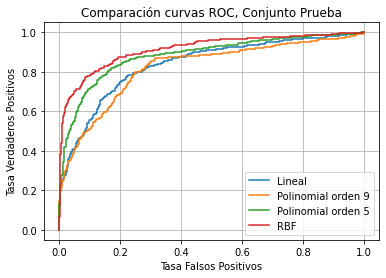

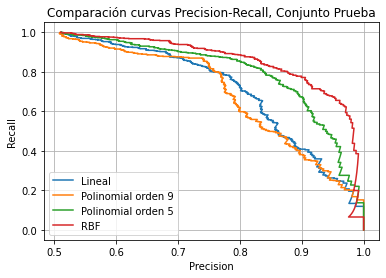

In [ ]:
#Gráfico comparativo de las curvas roc

plt.plot(FPR_test,TPR_test, label='Lineal')
plt.plot(FPR_poly9_test,TPR_poly9_test, label='Polinomial orden 9')
plt.plot(FPR_poly5_test,TPR_poly5_test, label='Polinomial orden 5')
plt.plot(FPR_rbf_test,TPR_rbf_test, label='RBF')
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Comparación curvas ROC, Conjunto Prueba')
plt.legend()
plt.grid()
plt.show()

#Gráfico comparativo curvas precision-recall

plt.plot(precision_test,recall_test, label='Lineal')
plt.plot(precision_poly9_test,recall_poly9_test, label='Polinomial orden 9')
plt.plot(precision_poly5_test,recall_poly5_test, label='Polinomial orden 5')
plt.plot(precision_rbf_test,recall_rbf_test, label='RBF')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Comparación curvas Precision-Recall, Conjunto Prueba')
plt.legend()
plt.grid()
plt.show()
